In [1]:
# Use these commands in the same cell.
%load_ext autoreload
%autoreload 2
from base_model_backtest import backtest

ModuleNotFoundError: No module named 'base_model_backtest'

In [5]:
df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
base = datetime.datetime.today()
date_list = [base + datetime.timedelta(days=x) for x in range(len(df))]
df.index = date_list
prices = np.array([df.ewc,df.ewa]).T


In [ ]:
delta = 0.0001
ve = 0.001


In [2]:
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from multiprocessing import Process
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import random
from mathCode.johansenMain import coint_johansen
from tqdm import tqdm_notebook
from IPython.display import clear_output
import itertools
import datetime
import os
from base_model_backtest import backtest
import random
from pandas_datareader import data as pdr
import logging
from pandas.plotting import register_matplotlib_converters
from functionSource import *

register_matplotlib_converters()
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
plt.style.use(['ggplot'])


from models.Cointegrated_Pairs_1 import cointegrated_pairs_1


        
global toTrade
global price
global df
global results
global runDate

#Ranges for parameters
# ve_values =  [round(0.1**(ve_), 11) for ve_ in range(2,10)]
# delta_values = [round(0.1**(delta_), 11) for delta_ in range(2,10)]
ve_values = [1e-09]
delta_values = [1e-05]

transactionFeesPercent = 0
minimumComission = 0
capitalPerTrade = 1

toTrade = ['GOLD.AX','OOO.AX']
riskFreeTs = '^AXJO'


data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
close = data.xs('CLOSE', axis = 1, level = 1)
close = close[toTrade].dropna()


#Create rundate and directory of logs and results
runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/MULTI_pairTradeKalman_' + flatten(toTrade) +'_'+ runDate 
try:
    os.makedirs(logDirectory)
except Exception as e:
    pass

results = setup_logger('results', logDirectory+'/results.log')
results.info('Delta, Ve, Final Returns Value, Number of Trades')



def runThatShitBack(delta, cointegrated_pairs_1):

    for ve in ve_values:

    
        #Update to include specific deltas and ve
        logDirectoryBatch = logDirectory +  '/delta_'+str(delta) + '_ve_'+str(ve)
        try:
            os.makedirs(logDirectoryBatch)
        except Exception as e:
            pass

        strategy = cointegrated_pairs_1(close[toTrade],
                            toTrade, 
                            3, 
                            False, 
                            False, 
                            decimalPlaces = None,
                            lookback = None, 
                            delta = delta,
                            ve = ve,
                            riskFreeTs = riskFreeTs,
                            logDir = logDirectoryBatch,
                            transactionFeesPercent = transactionFeesPercent,
                            minimumComission = minimumComission,
                            InitialCapital = 0,
                            capitalPerTrade = capitalPerTrade)

        #Run the
        strategy.run()


        #Print simmary of results
        results.info([delta, ve, np.cumsum(strategy.returns.values)[-1], strategy.numberOfTrades])

       #Re-index the returns, placing zero on days where no trades were made
        dates = strategy.dfHistory.index
        returns =  strategy.returns.T.reindex(dates, fill_value=0)
        plt.plot(returns)
        plt.show()
        #Calculate Drawdowns
        drawdownArray, drawDownDf = drawdowns(returns.returns)
            
        #Calculate Alpha, beta, sharpe values
        alpha, beta = alpha_beta(returns, riskFreeTs)
        sharpeRatio = sharpe(returns, riskFreeTs)
        APRvalue = APR(returns)
        #Print simmary of results
        results.info([delta, ve, np.cumsum(strategy.returns.values)[-1], strategy.numberOfTrades])

        print(len(returns), len(dates))

        plotResults(dates,
                    returns,
                    np.cumsum(returns),
                    riskFreeTs,
                    directory = logDirectoryBatch,
                    drawdownArray = drawdownArray,
                    maxDrawDown = round(min(drawdownArray),4),
                    maxDrawDownDuration = drawDownLength(drawDownDf),
                    alpha = round(alpha,4),
                    beta = round(beta,4),
                    sharpe = round(sharpeRatio,4),
                    APR = round(APRvalue,4),
                    additionalData = [['ve',str(ve)],
                                        ['delta',str(delta)],
                                        ['comission',str(transactionFeesPercent)],
                                        ['minComish',str(minimumComission)],
                                        ['capPerTr',str(capitalPerTrade)],
                                        ['numTrades',str(strategy.numberOfTrades)]])




        # except Exception as e:
        #     print(e)



if __name__ == '__main__':

    processes = []
    for delta in delta_values:
        process = Process(target=runThatShitBack, args=(delta, cointegrated_pairs_1))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()


    


In [26]:
df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')


In [35]:
toTrade = ['ewa','ewc']
close = df[toTrade]



ve = 0.001
delta = 0.0001

transactionFeesPercent = 0.0008
minimumComission = 0
capitalPerTrade = 1

logDirectoryBatch = logDirectory +  '/delta_'+str(delta) + '_ve_'+str(ve)

runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/MULTI_pairTradeKalmanEWAEWC_' + flatten(toTrade) +'_'+ runDate 

try:
    os.makedirs(logDirectory)
except Exception as e:
    pass

try:
    os.makedirs(logDirectoryBatch)
except Exception as e:
    pass

        
results = setup_logger('results', logDirectory+'/results.log')
results.info('Delta, Ve, Final Returns Value, Number of Trades')

strategy = cointegrated_pairs_1(close[toTrade],
                            toTrade, 
                            3, 
                            False, 
                            False, 
                            decimalPlaces = None,
                            lookback = None, 
                            delta = delta,
                            ve = ve,
                            riskFreeTs = riskFreeTs,
                            logDir = logDirectoryBatch,
                            transactionFeesPercent = transactionFeesPercent,
                            minimumComission = minimumComission,
                            InitialCapital = 0,
                            capitalPerTrade = capitalPerTrade)

strategy.run()

In [34]:
data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
close = data.xs('CLOSE', axis = 1, level = 1)
close = close[toTrade].dropna()

toTrade = ['GOLD.AX','OOO.AX']


ve = 1e-09
delta = 1e-05

transactionFeesPercent = 0
minimumComission = 0
capitalPerTrade = 1

logDirectoryBatch = logDirectory +  '/delta_'+str(delta) + '_ve_'+str(ve)

runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/MULTI_pairTradeKalman_' + flatten(toTrade) +'_'+ runDate 

try:
    os.makedirs(logDirectory)
except Exception as e:
    pass

try:
    os.makedirs(logDirectoryBatch)
except Exception as e:
    pass

        
results = setup_logger('results', logDirectory+'/results.log')
results.info('Delta, Ve, Final Returns Value, Number of Trades')

KeyError: "None of [Index(['ewa', 'ewc'], dtype='object')] are in the [columns]"

In [17]:
close[toTrade]

,GOLD.AX,OOO.AX
Date,,
2011-11-16,169.86,54.81
2011-11-17,168.68,56.90
2011-11-18,167.01,54.60
2011-11-22,165.80,53.55
2011-11-23,169.39,53.70
2011-11-24,168.50,53.00
2011-11-25,169.12,53.28
2011-11-30,166.54,55.20
2011-12-06,163.41,55.75


In [15]:
strategy = cointegrated_pairs_1(close[toTrade],
                            toTrade, 
                            3, 
                            False, 
                            False, 
                            decimalPlaces = None,
                            lookback = None, 
                            delta = delta,
                            ve = ve,
                            riskFreeTs = riskFreeTs,
                            logDir = logDirectoryBatch,
                            transactionFeesPercent = transactionFeesPercent,
                            minimumComission = minimumComission,
                            InitialCapital = 0,
                            capitalPerTrade = capitalPerTrade)

strategy.run()

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


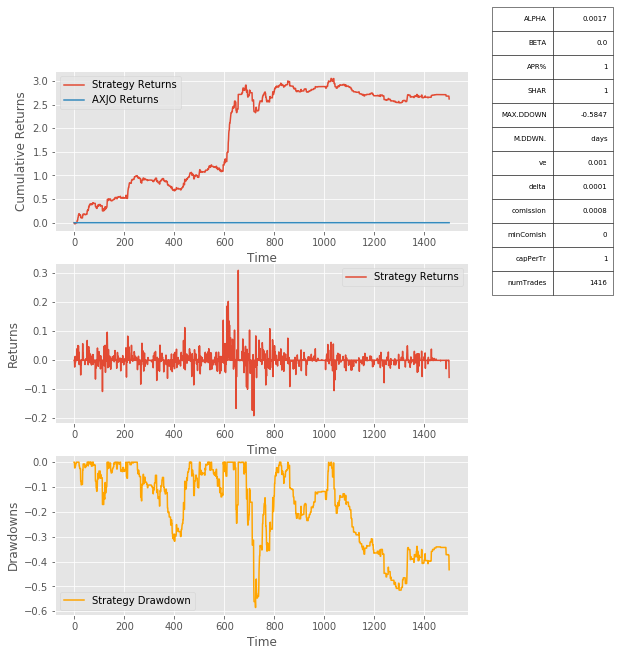

In [36]:
dates = strategy.dfHistory.Date
returns =  strategy.returns.T.reindex(dates, fill_value=0)

#Calculate Drawdowns
drawdownArray, drawDownDf = drawdowns(returns.returns)

#Calculate Alpha, beta, sharpe values
alpha, beta = alpha_beta(returns, riskFreeTs)
# sharpeRatio = sharpe(returns, riskFreeTs)
sharpeRatio = 1
# APRvalue = APR(returns)
APRvalue =1
plotResults(dates,
                    returns,
                    np.cumsum(returns),
                    riskFreeTs,
                    directory = logDirectoryBatch,
                    drawdownArray = drawdownArray,
                    maxDrawDown = round(min(drawdownArray),4),
                    maxDrawDownDuration = drawDownLength(drawDownDf),
                    alpha = round(alpha,4),
                    beta = round(beta,4),
                    sharpe = round(sharpeRatio,4),
                    APR = round(APRvalue,4),
                    additionalData = [['ve',str(ve)],
                                        ['delta',str(delta)],
                                        ['comission',str(transactionFeesPercent)],
                                        ['minComish',str(minimumComission)],
                                        ['capPerTr',str(capitalPerTrade)],
                                        ['numTrades',str(strategy.numberOfTrades)]])

In [23]:
strategy.dfHistory.head()

,Date,GOLD.AX,OOO.AX
0,2011-11-16,169.86,54.81
0,2011-11-17,168.68,56.90
0,2011-11-18,167.01,54.60
0,2011-11-22,165.80,53.55
0,2011-11-23,169.39,53.70


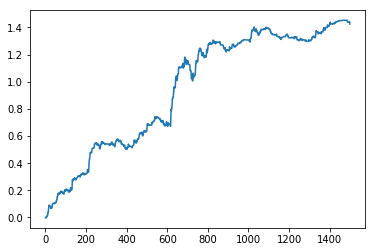

In [27]:
plt.plot(np.cumsum(o.returns))

In [32]:

import bs4 as bs
from bs4 import BeautifulSoup

import urllib.request
import requests
rows = []
for index, row in enumerate(soup.find('table').findAll('tr')):
    if index == 0:
        rowTemp = row.text.split('\n')
        colNames = [x for x in rowTemp if x != '']
    else:
        rowTemp = row.text.split('\n')
        rowTemp = [x for x in rowTemp if x != '']
        rows.append(rowTemp)
etfs = pd.DataFrame(rows)
etfs.columns = colNames
codes = []
for index, etf in etfs.iterrows():
    code = etf['ASX Code'] + '.AX'
    codes.append(code)

for code in codes:
    url = 'https://finance.yahoo.com/quote/ETF.AX/history?p='+code
    headers = {'User-Agent':'Mozilla/5.0'}
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    print(soup.find('tbody'))
    break
import fix_yahoo_finance as fyf
from pandas_datareader import data as pdr
price = pdr.get_data_yahoo(codes[:40], start = '2015-01-01')

NameError: name 'soup' is not defined

In [26]:
from pandas_datareader import data as pdr


In [8]:
df = price.Close.dropna()
toTrade = ['LNG.AX','STO.AX']
values = []
for delta_ in range(1,7):
    for ve_ in range (1,7):
        try:
            delta = 0.1**delta_
            ve = 0.1**ve_
            o = cointegrated_pairs_1(df[toTrade], toTrade, 3, False, False, 
                    decimalPlaces = None,
                    lookback = None, 
                    delta = delta,
                    ve = ve,
                    capitalPerTrade = 1)
            temp = [delta, ve, np.cumsum(o.returns)[-1]]
            print(temp)
            values.append(temp)
        except Exception as e:
            print(e)

name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'coint

In [7]:
toTrade = ['GOLD.AX','OSH.AX']

price = pdr.get_data_yahoo(toTrade, start = '2010-01-01')

In [155]:
#Maximum [1.0000000000000003e-05, 0.0010000000000000002, 3.533554237991313]
def flatten(list_):
    string = ''
    for element in list_:
        string = string + element.replace('.','')+'_'

    return string

# toTrade = ['GOLD.AX','OSH.AX']
# price = pdr.get_data_yahoo(toTrade, start = '2010-01-01')
# df = price.Close.dropna()
toTrade = ['ewa','ewc']
        
values = []
# for delta_ in range(1,7):
#     for ve_ in range (1,7):
try:
#     delta = 0.0001 + 0.1**(4+delta_)
#     ve = 0.0001 + 0.1**(4+ve_)
    delta = 0.0001 
    ve = 0.001
    runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-7]
    logDirectory = 'pairTradeKalman_' + flatten(toTrade) +'_'+ runDate + '_delta_'+str(delta) + '_ve_'+str(ve)
    logDirectory = 'C:/Users/Billy/Documents/PRISMO/logs/'+ logDirectory
    os.mkdir(logDirectory)

    strategy = cointegrated_pairs_1(df[toTrade], toTrade, 3, False, False, 
                        decimalPlaces = None,
                        lookback = None, 
                        delta = delta,
                        ve = ve,
                        capitalPerTrade = 300,
                        logDir = logDirectory)

    temp = [delta, ve, np.cumsum(strategy.returns)[-1]]
    print(temp)
    values.append(temp)

except Exception as e:
    print(e)
 


[1e-06, 1e-09, 1.4569634328817151]


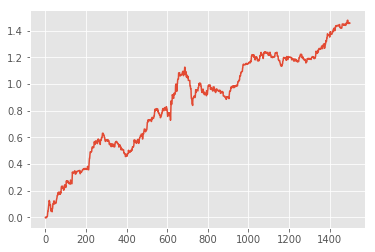

In [157]:
plt.plot(np.cumsum(strategy.returns))

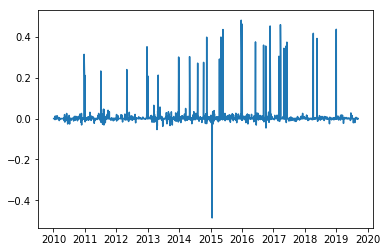

In [20]:
plt.plot(strategy.dfHistory.Date, strategy.returns)
plt.show()

Text(0.5, 1.0, 'Cumulative Returns')

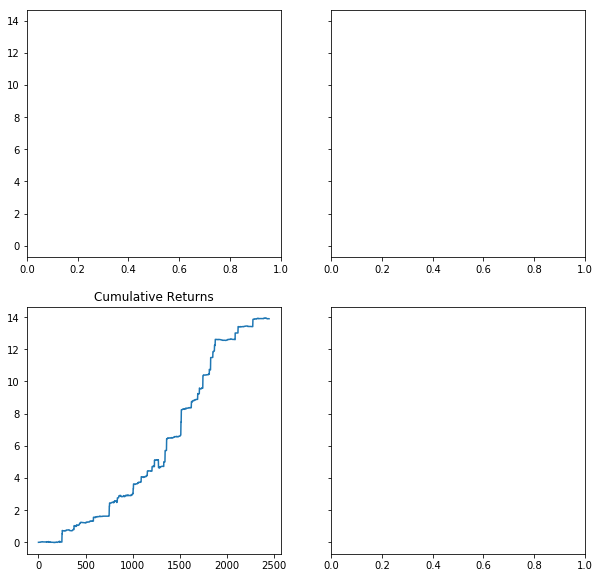

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
            # axs[0,0].plot(strategy.dfHistory)
            # axs[0,0].set_title('Original Series(s)')

axs[1,0].plot(np.cumsum(strategy.returns))
axs[1,0].set_title('Cumulative Returns')

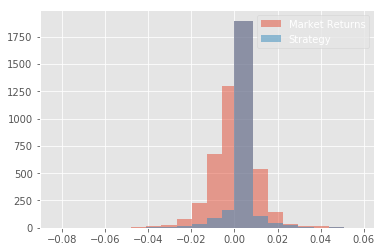

In [145]:
plt.style.use(['ggplot'])
n, bins, patches = plt.hist(marketReturns, 20, alpha = 0.5 )

binsWithZero =sorted(bins.tolist()+[0])
binsWithZero.remove(binsWithZero[binsWithZero.index(0)+1])

plt.clf()

#Gotta include 0, delete the proceeding element

plt.hist(marketReturns, binsWithZero, alpha = 0.5 )
plt.hist(strategy.returns, binsWithZero, alpha = 0.5)
plt.legend(['Market Returns','Strategy'])

plt.show()

In [152]:
marketReturns[strategy.dfHistory.Date]

Date
2010-01-03    0.001170
2010-01-04    0.009844
2010-01-05   -0.000589
2010-01-06   -0.004470
2010-01-07    0.002592
2010-01-10    0.007858
2010-01-11   -0.010342
2010-01-12   -0.006409
2010-01-13    0.006142
2010-01-14    0.000327
2010-01-17    0.002347
2010-01-18   -0.010161
2010-01-19    0.001440
2010-01-20   -0.008422
2010-01-21   -0.015868
2010-01-24   -0.006883
2010-01-26   -0.015537
2010-01-27    0.006179
2010-01-28   -0.022190
2010-01-31   -0.009957
2010-02-01    0.017948
2010-02-02    0.009250
2010-02-03   -0.005658
2010-02-04   -0.023260
2010-02-07    0.001617
2010-02-08   -0.003605
2010-02-09    0.001842
2010-02-10    0.009062
2010-02-11    0.001713
2010-02-14   -0.003639
                ...   
2019-07-29    0.004769
2019-07-30    0.002828
2019-07-31   -0.004748
2019-08-01   -0.003479
2019-08-02   -0.002990
2019-08-05   -0.018955
2019-08-06   -0.024427
2019-08-07    0.006391
2019-08-08    0.007455
2019-08-09    0.002482
2019-08-12    0.000896
2019-08-13   -0.003308
2019-0

In [153]:
np.cumsum(marketReturns)

Date
2000-01-04   -0.024243
2000-01-05   -0.030669
2000-01-06   -0.022634
2000-01-09   -0.002591
2000-01-10    0.022312
2000-01-11   -0.000593
2000-01-12   -0.003669
2000-01-13    0.008185
2000-01-16    0.010143
2000-01-17    0.012226
2000-01-18   -0.002960
2000-01-19    0.007428
2000-01-20   -0.005134
2000-01-23   -0.006338
2000-01-24   -0.013179
2000-01-26   -0.012293
2000-01-27   -0.007967
2000-01-30   -0.002877
2000-01-31   -0.005442
2000-02-01    0.006927
2000-02-02    0.017247
2000-02-03    0.009705
2000-02-06    0.015541
2000-02-07    0.014808
2000-02-08    0.019689
2000-02-09    0.033150
2000-02-10    0.025318
2000-02-13    0.011079
2000-02-14    0.020720
2000-02-15    0.020117
                ...   
2019-07-29    1.023481
2019-07-30    1.026308
2019-07-31    1.021560
2019-08-01    1.018081
2019-08-02    1.015091
2019-08-05    0.996136
2019-08-06    0.971710
2019-08-07    0.978100
2019-08-08    0.985555
2019-08-09    0.988036
2019-08-12    0.988933
2019-08-13    0.985625
2019-0

In [141]:
binsWithZero =sorted(bins.tolist()+[0])
binsWithZero.remove(binsWithZero[binsWithZero.index(0)+1])
binsWithZero.remove(binsWithZero[binsWithZero.index(0)-1])

In [142]:
binsWithZero

[-0.0833622530752205,
 -0.0762993373641241,
 -0.06923642165302771,
 -0.06217350594193131,
 -0.05511059023083491,
 -0.048047674519738515,
 -0.04098475880864212,
 -0.03392184309754572,
 -0.02685892738644933,
 -0.01979601167535293,
 -0.012733095964256536,
 0,
 0.008455651169032644,
 0.01551856688012905,
 0.022581482591225444,
 0.029644398302321837,
 0.03670731401341823,
 0.04377022972451464,
 0.050833145435611016,
 0.05789606114670742]

In [123]:
sorted(bins.tolist()+[0])

[-0.0833622530752205,
 -0.07663566668370012,
 -0.06990908029217974,
 -0.06318249390065936,
 -0.05645590750913899,
 -0.04972932111761861,
 -0.04300273472609824,
 -0.03627614833457786,
 -0.02954956194305748,
 -0.022822975551537103,
 -0.016096389160016725,
 -0.009369802768496346,
 -0.002643216376975982,
 0,
 0.004083370014544396,
 0.010809956406064775,
 0.017536542797585153,
 0.02426312918910553,
 0.03098971558062591,
 0.03771630197214629,
 0.044442888363666666,
 0.051169474755187044,
 0.05789606114670742]

In [89]:
marketReturns = df.pct_change() 
marketReturns = marketReturns[np.abs(marketReturns-marketReturns.mean()) <= 1]

In [76]:
marketReturns[np.abs(marketReturns-marketReturns.mean()) >1]

Series([], Name: Adj Close, dtype: float64)

(array([   6.,   13.,   53.,  178.,  607., 1021.,  430.,  103.,   25.,
           3.]),
 array([-0.04090444, -0.03316189, -0.02541934, -0.01767679, -0.00993424,
        -0.00219169,  0.00555085,  0.0132934 ,  0.02103595,  0.0287785 ,
         0.03652105]),
 <a list of 10 Patch objects>)

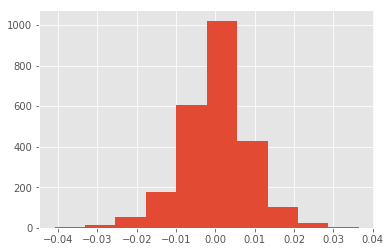

In [77]:
plt.hist(marketReturns)

In [86]:

price = pdr.get_data_yahoo('^AXJO', start = '2000-01-01', interval = 'd')
df = price['Adj Close']

ValueError: ('Unknown string format:', 'max')

In [84]:
df

Date
2000-01-03     3093.699951
2000-01-04     3018.699951
2000-01-05     2999.300049
2000-01-06     3023.399902
2000-01-09     3084.000000
2000-01-10     3160.800049
2000-01-11     3088.399902
2000-01-12     3078.899902
2000-01-13     3115.399902
2000-01-16     3121.500000
2000-01-17     3128.000000
2000-01-18     3080.500000
2000-01-19     3112.500000
2000-01-20     3073.399902
2000-01-23     3069.699951
2000-01-24     3048.699951
2000-01-26     3051.399902
2000-01-27     3064.600098
2000-01-30     3080.199951
2000-01-31     3072.300049
2000-02-01     3110.300049
2000-02-02     3142.399902
2000-02-03     3118.699951
2000-02-06     3136.899902
2000-02-07     3134.600098
2000-02-08     3149.899902
2000-02-09     3192.300049
2000-02-10     3167.300049
2000-02-13     3122.199951
2000-02-14     3152.300049
                  ...     
2019-08-01     6788.899902
2019-08-02     6768.600098
2019-08-05     6640.299805
2019-08-06     6478.100098
2019-08-07     6519.500000
2019-08-08     6568.100

In [87]:
df[strategy.dfHistory.Date]

Date
2010-01-03     4876.299805
2010-01-04     4924.299805
2010-01-05     4921.399902
2010-01-06     4899.399902
2010-01-07     4912.100098
2010-01-10     4950.700195
2010-01-11     4899.500000
2010-01-12     4868.100098
2010-01-13     4898.000000
2010-01-14     4899.600098
2010-01-17     4911.100098
2010-01-18     4861.200195
2010-01-19     4868.200195
2010-01-20     4827.200195
2010-01-21     4750.600098
2010-01-24     4717.899902
2010-01-26     4644.600098
2010-01-27     4673.299805
2010-01-28     4569.600098
2010-01-31     4524.100098
2010-02-01     4605.299805
2010-02-02     4647.899902
2010-02-03     4621.600098
2010-02-04     4514.100098
2010-02-07     4521.399902
2010-02-08     4505.100098
2010-02-09     4513.399902
2010-02-10     4554.299805
2010-02-11     4562.100098
2010-02-14     4545.500000
                  ...     
2019-07-29     6825.799805
2019-07-30     6845.100098
2019-07-31     6812.600098
2019-08-01     6788.899902
2019-08-02     6768.600098
2019-08-05     6640.299

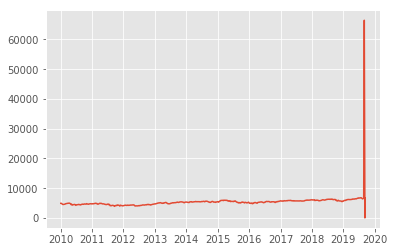

In [49]:
plt.plot(df)

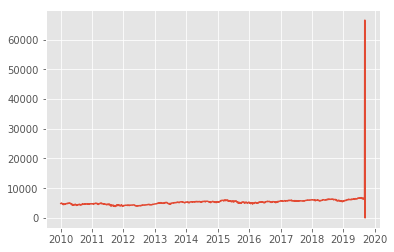

In [36]:
plt.plot(df)

In [62]:
max([x[2] for x in values])

3.533554237991313

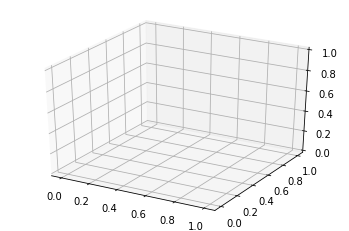

In [44]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = [x[0] for x in values],ys = [x[1] for x in values],zs = [x[2] for x in values] )

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


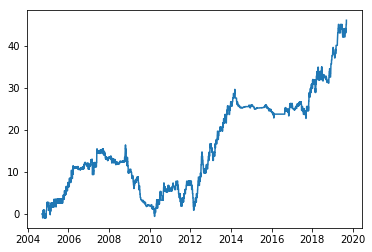

In [57]:
plt.plot(df.index, np.cumsum(o.returns))

In [73]:
import os
os.mkdir('C:/Users/Billy/Documents/PRISMO/logs/yo')

In [92]:
runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-7]

In [112]:
def flatten(list_):
    string = ''
    for element in list_:
        string = string + element.replace('.','')+'_'
    return string

directory = 'pairTradeKalman_' + flatten(toTrade) +'_'+ runDate

In [113]:
print(directory)

pairTradeKalman_LNGAX_STOAX__2019_09_08_16_36_33


In [103]:
print(flatten(toTrade))

LNG.AX
STO.AX
LNGAX_STOAX_


In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs[0,0].plot(x, y)
axs[0,0].set_title('yo')
axs[1,0].plot(x, y)
axs[0,1].plot(x, y)

fig.savefig('C:/Users/Billy/Documents/PRISMO/results/pic.jpg')   # save the figure to file
plt.close(fig)    # close the figure

In [21]:
strategy.pnl

NameError: name 'strategy' is not defined

In [31]:
for line in open('C:/Users/Billy/Documents/PRISMO/results/cointegrated_pairs_1_2019_09_09_14_06_16.log', 'r'):
    print(line)

2019-09-09 14:06:56,418 INFO [0.1, 0.1, 0]

2019-09-09 14:06:57,475 INFO [0.01, 0.1, 0]

2019-09-09 14:07:04,071 INFO [0.001, 0.1, 0.5937150482054959]

2019-09-09 14:07:10,078 INFO [0.0001, 0.1, 10.551216456244072]

2019-09-09 14:07:10,914 INFO [1e-05, 0.1, 12.376083662933038]

2019-09-09 14:07:18,245 INFO [1e-09, 0.1, 12.938888795772204]

2019-09-09 14:07:19,205 INFO [1e-06, 0.1, 15.134275995396727]

2019-09-09 14:07:29,260 INFO [1e-08, 0.1, 15.606148696242698]

2019-09-09 14:07:32,737 INFO [1e-07, 0.1, 17.19891416143309]

2019-09-09 14:08:04,335 INFO [0.1, 0.01, 0]

2019-09-09 14:08:04,335 INFO [0.1, 0.01, 0]

2019-09-09 14:08:06,057 INFO [0.01, 0.01, 0]

2019-09-09 14:08:06,057 INFO [0.01, 0.01, 0]

2019-09-09 14:08:20,435 INFO [0.001, 0.01, 0.5937242092245394]

2019-09-09 14:08:20,435 INFO [0.001, 0.01, 0.5937242092245394]

2019-09-09 14:08:30,866 INFO [0.0001, 0.01, 10.552339285388966]

2019-09-09 14:08:30,866 INFO [0.0001, 0.01, 10.552339285388966]

2019-09-09 14:08:37,614 INFO [


2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:23:42,839 INFO [0.001, 1e-07, 0.5937252482102255]

2019-09-09 14:23:42,839 INFO [0.001, 1e-07, 0.5937252482102255]

2019-09-09 14:23:42,839 INFO [0.001, 1e-07, 0.5937


2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:23,062 INFO [1e-09, 1e-06, 23.149083501446235]

2019-09-09 14:37:23,062 INFO [1e-09, 1e-06, 23.149083501446235]

2019-09-09 14:37:23,062 INFO [1e-09, 1e-06, 23.149083501446235]

2019-09-09 14:37:23,062 

In [40]:
df = pickle.load(open('D:/Crypto_data/ohlc_data/poloniex/1d/BTC-USDT_data.pickle','rb'))
df2 = pickle.load(open('D:/Crypto_data/ohlc_data/poloniex/1d/ETH-USDT_data.pickle','rb'))

In [42]:
df2.Close

Date
2015-08-08 09:30:00      1.400000
2015-08-09 09:30:00      1.400000
2015-08-10 09:30:00      1.400000
2015-08-11 09:30:00      1.100000
2015-08-12 09:30:00      1.380000
2015-08-13 09:30:00      2.140000
2015-08-14 09:30:00      2.150000
2015-08-15 09:30:00      1.500000
2015-08-16 09:30:00      1.120000
2015-08-17 09:30:00      1.520000
2015-08-18 09:30:00      1.010000
2015-08-19 09:30:00      1.300000
2015-08-20 09:30:00      1.730000
2015-08-21 09:30:00      1.500000
2015-08-22 09:30:00      1.330001
2015-08-23 09:30:00      1.500000
2015-08-24 09:30:00      1.300000
2015-08-25 09:30:00      1.050000
2015-08-26 09:30:00      1.000000
2015-08-27 09:30:00      1.270000
2015-08-28 09:30:00      1.060000
2015-08-29 09:30:00      1.060000
2015-08-30 09:30:00      1.270000
2015-08-31 09:30:00      1.300000
2015-09-01 09:30:00      1.250001
2015-09-02 09:30:00      1.260001
2015-09-03 09:30:00      1.370000
2015-09-04 09:30:00      1.219400
2015-09-05 09:30:00      1.373368
2015-09-0

In [45]:
df = pd.concat([df.Close,df2.Close], axis=1)

In [48]:
df.columns = ['BTC','ETH']

In [49]:
df

,BTC,ETH
Date,,
2015-02-19 10:30:00,244.000000,NaN
2015-02-20 10:30:00,240.250000,NaN
2015-02-21 10:30:00,245.000000,NaN
2015-02-22 10:30:00,235.000000,NaN
2015-02-23 10:30:00,235.000000,NaN
2015-02-24 10:30:00,239.750000,NaN
2015-02-25 10:30:00,237.750000,NaN
2015-02-26 10:30:00,238.500000,NaN
2015-02-27 10:30:00,249.000000,NaN


In [52]:
# toTrade = ['UBU.AX','SSO.AX']
# riskFreeTs = '^AXJO'
# data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
# close = data.xs('CLOSE', axis = 1, level = 1)
# close_ = close[toTrade]
# close = close_
df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
df.set_index('Date',inplace=True)
toTrade = ['ewa','ewc']
close = df[toTrade]
# ve_values = [x/10000000 for x in range(0,10000000,1000)]
# delta_values = [0.0001]
ve_values = []
delta_values = []
for ve_ in range(1,10):
    order = round(0.1**(ve_), 8)
    for i in range(1,10):
        ve_values.append(round(i*order,11))
        delta_values.append(round(i*order,11))


In [73]:
flatten(toTrade)

'ewa_ewc_'

In [53]:
def monotonicityMeasure(returns):
     # Start by counting how many points in the future returns are greater than the current
     # If its less than current, we want to emphasise that it's non monatonic in the long run and is a bad strategy
    # Check x chunks for monotonicity
    chunks = 50
    binWidth = int(len(returns)/chunks)
    
    totalCounter = 0
    monotonicCounter = 0
    for i in range(0,len(returns),binWidth):
        for j in range(i+chunks,len(returns),binWidth):
            
            if returns[j]>returns[i]:
                monotonicCounter +=1
            
            totalCounter+=1
            
    return monotonicCounter/totalCounter
    

In [71]:
results=[]
# for delta in tqdm_notebook(delta_values):
#     for Ve in tqdm_notebook(ve_values):
        
for delta in [0.0001]:
    for Ve in [0.001]:

        #INIT
        yhatList = []
        QList= []
        eList=[]
        betaList = [np.matrix([[0],[0]])]
        R = np.zeros([len(toTrade),len(toTrade)])
        P = np.zeros([len(toTrade),len(toTrade)])
        y = []
        hedges = []
        Vw = delta/(1-delta)*np.diag(np.ones(len(toTrade)))

        for row in close.iterrows():
            #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
            x = np.matrix([[row[1][toTrade[0]]],[1]])
            y = np.matrix(row[1][toTrade[1]])

            ## 1 STEP AHEAD PREDICTION ##
            beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
            R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
            yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
            e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
            Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
            #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
            #                                                                             = x . R(t|t-1) + Ve


            ## UPDATE PARAMETERS ##
            K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
            beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
            P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

            #Add beta and predicted y values to arrays for storage
            betaList.append(beta)
            yhatList.append(yhat)

            #Form the hedge ratio as a float
            hedgeRatio = beta[0].tolist()[0][0]
            hedges.append(hedgeRatio)
            eList.append(e_t.tolist()[0][0])
            QList.append(Q_t.tolist()[0][0])

        close['e'] = eList
        close["Q"] = QList
        
        if np.mean(close['e'])>np.mean(close['Q']):
            print(np.mean(close['e']), np.mean(close['Q']))
#             if the average error is greater than the average error, the parameters are fucked. No point going further

            break
    
    
    
        close['LongEntry'] = close['e']<-np.sqrt(close['Q'])
        close['LongExit'] = close['e']>-np.sqrt(close['Q'])
        close['ShortEntry'] = close['e']>np.sqrt(close['Q'])
        close['ShortExit'] = close['e']<np.sqrt(close['Q'])
        ratios = hedges
        numUnitsLong = np.array([[np.nan]]*len(close))
        numUnitsShort = np.array([[np.nan]]*len(close))

        numUnitsLong[0] = 1
        numUnitsLong[np.array(close['LongEntry'])] = 1
        numUnitsLong[np.array(close['LongExit'])] = 0

        numUnitsShort[0] = 1
        numUnitsShort[np.array(close['ShortEntry'])] = -1
        numUnitsShort[np.array(close['ShortExit'])] = 0

        close['short'] = numUnitsShort
        close['short'].fillna('ffill')
        close['long'] =  numUnitsLong
        close['long'].fillna('ffill')

        close['numUnits'] = close['long'] + close['short']

        close['numUnits'+toTrade[0]] = -close['numUnits']*ratios
        close['numUnits'+toTrade[1]] = close['numUnits']

        close['positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
        close['positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]

        close['pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))

        close['returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)

        sharpe = (np.mean(close['returns']))
        try:
            numTrades = len(close[close['numUnits']!=0])/2
            if numTrades > 50:
                monotonicity = monotonicityMeasure(np.cumsum(close['returns'].fillna(0)))
                weightedSharpe = monotonicity*sharpe
                weightedRet = monotonicity*np.cumsum(close['returns'].fillna(0)).iloc[-1]
        
        
                results.append([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])
        except Exception as e:
            print(e)

In [72]:
results

[[0.0001,
  0.001,
  1.5664478087079938,
  0.002212496904954793,
  1.5127410266951484,
  0.002136639868213486]]

<IPython.core.display.Javascript object>


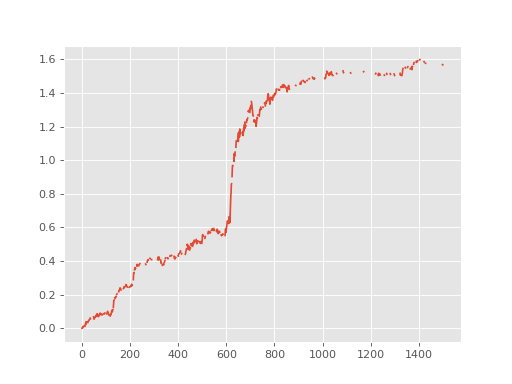

In [62]:
# resultsbackup = results
%matplotlib notebook

plt.plot(np.cumsum(close['returns']))

In [49]:
close

,UBU.AX,SSO.AX,e,Q,LongEntry,LongExit,ShortEntry,ShortExit,short,long,numUnits,numUnitsUBU.AX,numUnitsSSO.AX,positionsUBU.AX,positionsSSO.AX,pnl,returns
Date,,,,,,,,,,,,,,,,,
2007-10-10,NaN,NaN,NaN,NaN,False,False,False,False,1.0,1.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN
2007-10-11,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-12,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-15,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-16,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-17,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-18,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-19,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-22,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


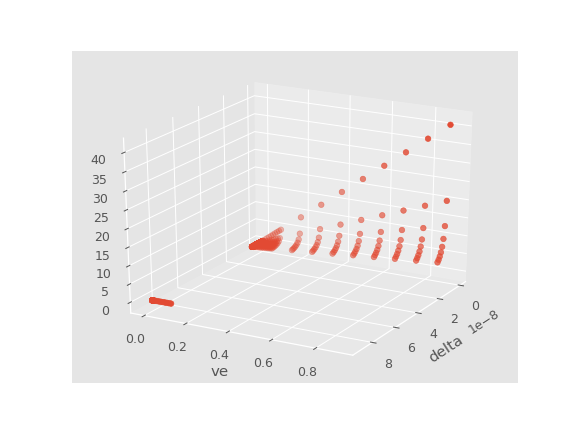

Text(0.5, 0, 've')

In [37]:
%matplotlib notebook
sharpe = [c[2] for c in resultsbackup]
delta = [c[0] for c in resultsbackup]
ve = [c[1] for c in resultsbackup]
cumRet = [c[3] for c in resultsbackup]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(delta[-800:], ve[-800:], cumRet[-800:])
ax.set_xlabel('delta')
ax.set_ylabel('ve')

In [55]:
results

[]

In [121]:
for row in close.iterrows():
    #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
    x = np.matrix([[row[1][toTrade[0]]],[1]])
    y = np.matrix(row[1][toTrade[1]])

    ## 1 STEP AHEAD PREDICTION ##
    beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
    R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
    yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
    e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
    Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
    #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
    #                                                                             = x . R(t|t-1) + Ve


    ## UPDATE PARAMETERS ##
    K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
    beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
    P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

    #Add beta and predicted y values to arrays for storage
    betaList.append(beta)
    yhatList.append(yhat)

    #Form the hedge ratio as a float
    hedgeRatio = beta[0].tolist()[0][0]
    hedges.append(hedgeRatio)
    eList.append(e_t.tolist()[0][0])
    QList.append(Q_t.tolist()[0][0])

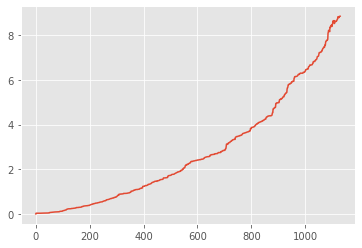

In [122]:
constants = [x.tolist()[1][0] for x in betaList]
plt.plot(constants)

In [123]:
close['e'] = eList
close["Q"] = QList

In [124]:
len(close)

1130

In [125]:
close['LongEntry'] = close['e']<-np.sqrt(close['Q'])
close['LongExit'] = close['e']>-np.sqrt(close['Q'])
close['ShortEntry'] = close['e']>np.sqrt(close['Q'])
close['ShortExit'] = close['e']<np.sqrt(close['Q'])

In [126]:
ratios = hedges
numUnitsLong = np.array([[np.nan]]*len(close))
numUnitsShort = np.array([[np.nan]]*len(close))

numUnitsLong[0] = 1
numUnitsLong[np.array(close['LongEntry'])] = 1
numUnitsLong[np.array(close['LongExit'])] = 0

numUnitsShort[0] = 1
numUnitsShort[np.array(close['ShortEntry'])] = -1
numUnitsShort[np.array(close['ShortExit'])] = 0

close['short'] = numUnitsShort
close['short'].fillna('ffill')
close['long'] =  numUnitsLong
close['long'].fillna('ffill')

close['numUnits'] = close['long'] + close['short']
# numUnitsPortfolio = (numUnitsShort + numUnitsLong)
# numUnitsEachAsset = np.multiply(np.tile(numUnitsPortfolio, (1,2)), np.matrix(ratios).T)
# positions = pd.DataFrame(np.multiply(numUnitsEachAsset, A))

# #we calculate pnl by first calculating the percent change of price in each asset
# pnl = pd.DataFrame(positions).shift(1)*(pd.DataFrame(A) - pd.DataFrame(A).shift(1))/pd.DataFrame(A).shift(1)
# pnl = pnl.sum(axis=1)

# #returnzzzz bruh
# returns=pnl / np.sum(np.abs(positions.shift(1)),axis=1)
# cumulativeReturns = np.cumsum(returns, axis=0)

In [127]:
close['numUnits'+toTrade[0]] = -close['numUnits']*ratios
close['numUnits'+toTrade[1]] = close['numUnits']

In [128]:
close['positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
close['positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]

In [129]:
# close['pnl'+toTrade[0]] = 

In [130]:
close['pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))

In [139]:
close['returns'] = close['pnl']/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)

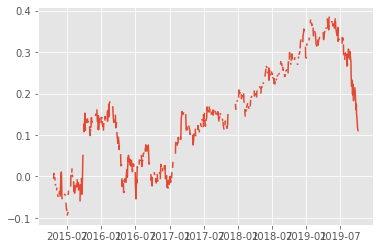

In [140]:
plt.plot(np.cumsum(close['returns']))

In [91]:
def KalmanFilter(df): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    y = np.transpose(np.matrix(df['ewc']))
    #augment x to account for constant offset
    x = np.transpose(np.matrix([df['ewa'],[1]*len(df)]))
    
    #measurement prediction
    yhat = [np.nan]*len(df)
    #measurement prediction error variance
    Q = [np.nan]*len(df)
    #measurement prediction error
    e = [np.nan]*len(df)
    #beta matrix
    beta = [[np.nan]*len(df.columns)]*len(df)
    #R is R(t|t)
    R = np.matrix[[np.nan,np.nan],[np.nan,np.nan]]
    
    #delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
    delta = 0.0001
    Vw = delta/(1-delta)*np.diag(np.ones(len(df.columns)))
    Ve = 0.001
    
    #initialise beta
    
    ratios = []
    for i in range(len(A)):
         #testcase:use ols to find hedge ratios instead
        if i > lookback:    
            ewc_Const = sm.add_constant(df['GLD'].values[i-lookback:i]) # we want to add a constant under the assumption that there can be a nonzero off set of the     pair portfolio’s price series
            model = sm.OLS(df['USO'].values[i-lookback:i],ewc_Const).fit()
            hedge_ratio = model.params[1]
            ratios.append(hedge_ratio)
        else:
            ratios.append(0)

    #for each 1 unit of USO, we hedge with the regressed values of GLD
    ratios = pd.DataFrame(-np.array(ratios))
    ratios['USO'] = pd.Series([1]*len(ratios))
    ratios.columns = ['GLD','USO']

    spread = np.array(df['USO'])+np.multiply(np.array(ratios['GLD']), np.array(df['GLD']))    
    #create rolling averages
    spread = pd.DataFrame(spread)
    marketValStd = np.array(spread.rolling(math.floor(lookback)).std())
    marketValMA = np.array(spread.rolling(math.floor(lookback)).mean())
    #calculate negative z score from moving average
    z = (spread - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))
    #BOLLINGER BAND COMPONENT
    entryZscore = 1
    exitZscore = 0
    
    longsEntry = z < -entryZscore    # a long position means we should buy USO
    longsExit = z >= -exitZscore     # sell our long position
    
    shortEntry = z > entryZscore     # create a short position, sell GLD
    shortExit = z <= exitZscore      # buy back our short
    
    numUnitsLong = np.array([[np.nan]]*len(z))
    numUnitsShort = np.array([[np.nan]]*len(z))
    
    numUnitsLong[0] = 1
    numUnitsLong[np.array(longsEntry)] = 1
    numUnitsLong[np.array(longsExit)] = 0
    
    numUnitsShort[0] = 1
    numUnitsShort[np.array(shortEntry)] = -1
    numUnitsShort[np.array(shortExit)] = 0
    
    #use pandas , .fillna(method='ffill') 
    for i in range(len(numUnitsLong)):
        if np.isnan(numUnitsLong[i][0]):
            numUnitsLong[i][0] = numUnitsLong[i-1] 
        if np.isnan(numUnitsShort[i][0]):
            numUnitsShort[i][0] = numUnitsShort[i-1] 

    numUnitsPortfolio = (numUnitsShort + numUnitsLong)
    numUnitsEachAsset = np.multiply(np.tile(numUnitsPortfolio, (1,2)), np.array(ratios))
    positions = pd.DataFrame(np.multiply(numUnitsEachAsset, A))
    
    #we calculate pnl by first calculating the percent change of price in each asset
    pnl = pd.DataFrame(positions).shift(1)*(pd.DataFrame(A) - pd.DataFrame(A).shift(1))/pd.DataFrame(A).shift(1)
    pnl = pnl.sum(axis=1)
    
    #returnzzzz bruh
    returns=pnl / np.sum(np.abs(positions.shift(1)),axis=1)
    cumulativeReturns = np.cumsum(returns, axis=0)


    sharpe = math.sqrt(252)*np.mean(returns)/np.std(returns)
    return cumulativeReturns, sharpe


plot, sharpe = KalmanFilter(close[['ewc','ewa']])
print(sharpe)
plt.plot(plot)
plt.title('EWC/EWA efts')
plt.show()

TypeError: 'type' object is not subscriptable